In [ ]:
import mechwolf as mw 
from datetime import timedelta
from astropy.table import QTable, Table, Column 
from sigfig import round
import time
import asyncio
from loguru import logger
import math

In [2]:
class HarvardSyringePump(mw.Pump):
    def __init__(self, syringe_volume, syringe_diameter, serial_port, name=None):
        super().__init__(name=name)
        self.serial_port = serial_port
        self.syringe_volume = mw._ureg.parse_expression(syringe_volume)
        self.syringe_diameter = mw._ureg.parse_expression(syringe_diameter)
        
    def __enter__(self):
        """Initialize the serial port and send syringe volume and diameter to pump"""
        import aioserial

        self._ser = aioserial.AioSerial(
            self.serial_port,
            115200,
            parity=aioserial.PARITY_NONE,
            stopbits=1,
            timeout=1,
            write_timeout=1,)
        """take input for syringe diameter and volume and give it to the apparatus"""
        syringe_volume_ml = self.syringe_volume.to(mw._ureg.ml).magnitude 
        syringe_diameter_mm = self.syringe_diameter.to(mw._ureg.mm).magnitude
        self._ser.write(f'svolume {syringe_volume_ml} ml\r'.encode())
        self._ser.write(f'diameter {syringe_diameter_mm}\r'.encode())

        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        """stop pump"""
        self.rate = mw._ureg.parse_expression("0 mL/min")
        self._ser.write(b'stop\r') 
        
      
        del self._ser

    async def _update(self):
        """update the pump between commands"""
        rate_mlmin = self.rate.to(mw._ureg.ml / mw._ureg.min).magnitude
        if rate_mlmin == 0:
            self._ser.write(b'stop\r') 
        else:
            self._ser.write(f'irate {rate_mlmin} m/m\r'.encode())
            self._ser.write(b'irun\r')

In [4]:
import math 

mL_to_inches = 16.3871

def tube_length():
    global mL_to_inches
    
    inner_diameter = float(input("Enter the inner diameter in inches: "))
    flow_rate = float(input("Enter the flow rate in mL/min: "))
    residence_time = float(input("Enter the residence time in seconds: "))

    area = math.pi * (inner_diameter / 2) ** 2
    rt_in_minutes = residence_time / 60
    answer = round((rt_in_minutes * flow_rate) / (area * mL_to_inches * 12), 2)
    print(f'The length of the reaction tube in feet should be: {answer}ft')
    
tube_length()

Enter the inner diameter in inches: 0.0625
Enter the flow rate in mL/min: 1
Enter the residence time in seconds: 600
The length of the reaction tube in feet should be: 17.0ft


In [ ]:
# to define serial port number, use the following command in temrinal: ls /dev/tty.usb* 

pump_1 = HarvardSyringePump("10ml", "12.45mm", serial_port = '/dev/tty.usbmodemD4038611')
pump_2 = HarvardSyringePump("20ml", "20.05mm", serial_port = '/dev/tty.usbmodemD4038591')
pump_3 = mw.VarianPump(max_rate = '5 mL/min', serial_port = '/dev/tty.usbserial-AR0KL34U')
pump_4 = mw.VarianPump(max_rate = '10mL/min', serial_port = '/dev/tty/usbserial-')
pump_5 = HarvardSyringePump("10ml", "12.45mm", serial_port = '/dev/tty.usbmodemD4038611')

In [ ]:
#reagent vessels
reagent_vessel_1 = mw.Vessel("L-rhamnal", name = "L-rhamnal in DMF")
reagent_vessel_2 = mw.Vessel("NaOMe", name = "NaOMe + MeOH in DMF")
reagent_vessel_3 = mw.Vessel("TBSCl", name = "TBSCl + DMAP")
reagent_vessel_4 = mw.Vessel("KHMDS", name = "KHMDS in THF")
reagent_vessel_5 = mw.Vessel("BnBR", name = "BnBr in DMF")
product_vessel = mw.Vessel("Product", name = "C-4 benzyl rhamnal")

#tubing
sugar = mw.Tube(length = "1 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")
NaOMe = mw.Tube(length = "1 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")
rxn_tube_1 = mw.Tube(length = "32 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")
TBSCl = mw.Tube(length = "1 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")
rxn_tube_2 = mw.Tube(length = "64 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")
KHMDS = mw.Tube(length = "1 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")
rxn_tube_3 = mw.Tube(length = "1 foot", ID = "0.062 in", OD = "1/8 in", material = "PFA")

#mixers
mixer_1 = mw.TMixer(name = "deacetylation")
mixer_2 = mw.TMixer(name = "protection")
mixer_3 = mw.TMixer(name = "deprotonation")

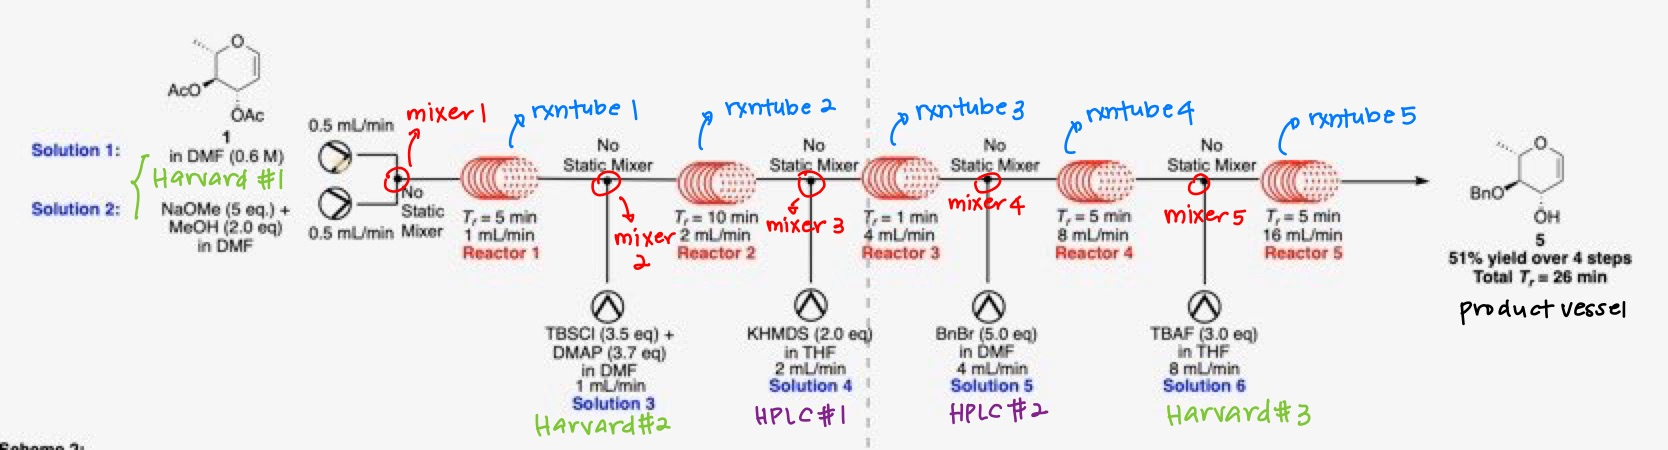

In [ ]:
A = mw.Apparatus("fully telescoped rxn")

# #deacetylation
A.add(pump_1, mixer_1, rxn_tube_1)
A.add(reagent_vessel_1, mixer_1, sugar)
A.add(reagent_vessel_2, mixer_1, NaOMe)

A.add(mixer_1, mixer_2, rxn_tube_1)

# #protection
A.add(pump_2, reagent_vessel_3, TBSCl)
A.add(reagent_vessel_3, mixer_2, TBSCl)

A.add(mixer_2, mixer_3, rxn_tube_2)

#deprotonation
A.add(pump_3, reagent_vessel_4, KHMDS)
A.add(reagent_vessel_4, mixer_3, KHMDS)
A.add(reagent_vessel_4, product_vessel, rxn_tube_3)

In [ ]:
P = mw.Protocol(A)

P.add(pump_1, start = timedelta(seconds = 0), duration = timedelta(seconds = 468), rate = "1ml/min")

# #pump 1 delay 30 seconds
P.add(pump_1, start = timedelta(seconds = 498), duration = timedelta(seconds = 600), rate = "1ml/min")
P.add(pump_2, start = timedelta(seconds = 630), duration = timedelta(seconds = 468), rate = "2ml/min")

# #delay 30 seconds 
P.add(pump_1, start = timedelta(seconds = 1128), duration = timedelta(seconds = 300), rate = "1ml/min")
P.add(pump_2, start = timedelta(seconds = 1128), duration = timedelta(seconds = 450), rate = "2ml/min")

P.add(pump, start = timedelta(seconds = 0), duration = timedelta(seconds = 10), rate = "1ml/min")

P.execute()